In [1]:
import pathlib as pl
import numpy as np
import modflowapi
import swiapi
import flopy

# path to mf6 shared library
# executables based on mf6 feat-swi branch at: 
#   https://github.com/langevin-usgs/modflow6/tree/feat-swi
mf6exe = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/mf6"
libmf6 = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/libmf6.dylib"


## MODFLOW-USG results for problem

In [2]:
hds_usg = np.array(
      [2.42414664e-16, 3.44822330e-01, 5.49943267e-01, 7.01957249e-01,
       8.24049181e-01, 9.26102851e-01, 1.01335249e+00, 1.08894584e+00,
       1.15494018e+00, 1.21276031e+00, 1.26343516e+00, 1.30773084e+00,
       1.34623039e+00, 1.37938411e+00, 1.40754251e+00, 1.43097863e+00,
       1.44990335e+00, 1.46447612e+00, 1.47481228e+00, 1.48098812e+00,
       1.48304388e+00, 1.48098812e+00, 1.47481228e+00, 1.46447612e+00,
       1.44990335e+00, 1.43097863e+00, 1.40754251e+00, 1.37938411e+00,
       1.34623039e+00, 1.30773084e+00, 1.26343516e+00, 1.21276031e+00,
       1.15494018e+00, 1.08894584e+00, 1.01335249e+00, 9.26102851e-01,
       8.24049181e-01, 7.01957249e-01, 5.49943267e-01, 3.44822330e-01,
       0.00000000e+00]
                  )

In [3]:
zeta_usg = np.array(
    [-9.69658656e-15, -1.37928932e+01, -2.19977307e+01, -2.80782900e+01,
       -3.29619672e+01, -3.70441140e+01, -4.05340994e+01, -4.35578338e+01,
       -4.61976073e+01, -4.85104122e+01, -5.05374063e+01, -5.23092336e+01,
       -5.38492157e+01, -5.51753643e+01, -5.63017003e+01, -5.72391451e+01,
       -5.79961342e+01, -5.85790447e+01, -5.89924913e+01, -5.92395247e+01,
       -5.93217551e+01, -5.92395247e+01, -5.89924913e+01, -5.85790447e+01,
       -5.79961342e+01, -5.72391451e+01, -5.63017003e+01, -5.51753643e+01,
       -5.38492157e+01, -5.23092336e+01, -5.05374063e+01, -4.85104122e+01,
       -4.61976073e+01, -4.35578338e+01, -4.05340994e+01, -3.70441140e+01,
       -3.29619672e+01, -2.80782900e+01, -2.19977307e+01, -1.37928932e+01,
        0.00000000e+00]
)

In [4]:
hds_usg.shape

(41,)

## Create and Run Simple Test Model

In [5]:
#create simple test model
Lx = 2050.0 # meters
ncol = 41
nlay = 1
nrow = 1
delr, delc = Lx / ncol, 1.0
top = 5.
botm = -80.
recharge = 1e-3
k = 10.
h0 = 0.0  
h1 = h0
icelltype = 1
newton_option = "newton"
if newton_option is None:
    linear_accel = "cg"
    max_outer = 50
else:
    linear_accel = "bicgstab"
    max_outer = 500

name = "usg_nr"
ws = pl.Path(f"temp/{name}")
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    sim_ws=ws, 
    exe_name=mf6exe,
    memory_print_option="all"
)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, outer_dvclose=1e-8, inner_dvclose=1e-9, linear_acceleration=linear_accel, outer_maximum=max_outer)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True, newtonoptions=newton_option)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    save_saturation=True,
    # alternative_cell_averaging="AMT-HMK",
    icelltype=icelltype,
    k=k,
)
# swi = flopy.mf6.ModflowGwfswi(gwf, zeta=zeta_usg.reshape((nlay, nrow, ncol)))
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=botm)
chd_spd = [
    ((0, 0, 0), h0),
    ((0, 0, ncol - 1), h1),
]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
        printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
sim.write_simulation()
#sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model usg_nr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


## Run Example Using API

### Run Model by Iteration

In [6]:
mf6_swi = swiapi.SwiAPI(libmf6, ws, name)
mf6_swi.run(maxiter=max_outer)


Initializing mf6...
Accessing pointer using tag: TDIS/DELT
Accessing pointer using tag: TDIS/NPER
Accessing pointer using tag: USG_NR/INSTO
Accessing pointer using tag: USG_NR/ISS
Accessing pointer using tag: USG_NR/X
Accessing pointer using tag: USG_NR/XOLD
Accessing pointer using tag: USG_NR/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: USG_NR/DIS/AREA
Accessing pointer using tag: USG_NR/DIS/TOP
Accessing pointer using tag: USG_NR/DIS/BOT
Accessing pointer using tag: USG_NR/NPF/SAT
Accessing pointer using tag: USG_NR/NPF/CONDSAT
Accessing pointer using tag: USG_NR/NPF/DERV_MULT
Accessing pointer using tag: USG_NR/SWI/ZETA
Accessing pointer using tag: USG_NR/SWI/HCOF
Accessing pointer using tag: USG_NR/SWI/RHS
Simulation end time = 1.0...

  Solving for time 0.0
  Prepare time step with dt=[0.]...
  Prepare solve...
    Solve...(kiter=0)
    Solve...(kiter=1)
    Solve...(kiter=2)
  

/Users/jdhughes/miniforge3/envs/develop/lib/python3.11/site-packages/xmipy/xmiwrapper.py:624: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c_dt = c_double(dt)


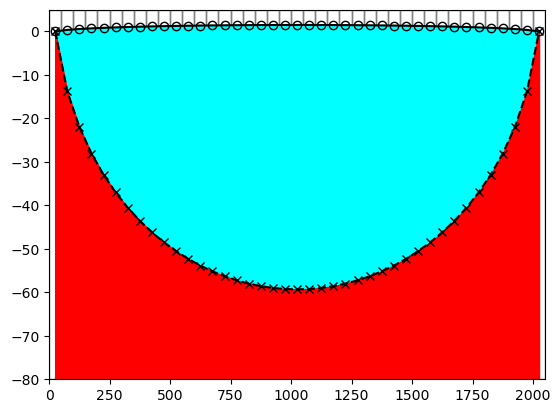

In [7]:
zeta = mf6_swi.zeta_last
x = gwf.modelgrid.xcellcenters.flatten()
head = gwf.output.head().get_data().flatten()
bud = gwf.output.budget()
#print(head.flatten())
#print(zeta.flatten())

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
ax = pxs.ax
if ncol < 50:
    pxs.plot_grid()
#pxs.plot_bc("ghb")
ax.plot(x, head, "k-")
ax.plot(x, zeta, "k--")
# freshwater
ax.fill_between(x, head, zeta, color="cyan")
# saltwater
ax.fill_between(x, zeta, botm, color="red")
# pxs.plot_vector(qx, qy, qz, normalize=True, color="black")

ax.plot(x, hds_usg, lw=0, mec="black", mfc="none", marker="o")
ax.plot(x, zeta_usg, lw=0, mec="black", mfc="none", marker="x");


In [8]:
fpth = pl.Path(ws) / f"{name}.dis.grb"
grb = flopy.mf6.utils.MfGrdFile(fpth)
ia = grb.ia
ja = grb.ja
nodes = grb.nodes
flowja = bud.get_data(text="FLOW-JA-FACE")[0].flatten()

# print flows bewteen cells
# for n in range(nodes):
#     for ipos in range(ia[n] + 1, ia[n + 1]):
#         m = ja[ipos]
#         q = flowja[ipos]
#         if m > n:
#             print(f"{n=} {m=} {q=}")

In [9]:
bobj = gwf.output.budget()

In [10]:
bobj.get_unique_record_names()

[b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'        DATA-SAT',
 b'            RCHA',
 b'             CHD',
 b'         STORAGE']

In [11]:
bobj.get_data(text="DATA-SAT")

[rec.array([( 1,  1, 0., 0.        ), ( 2,  2, 0., 0.1663259 ),
            ( 3,  3, 0., 0.2652667 ), ( 4,  4, 0., 0.33859116),
            ( 5,  5, 0., 0.39748261), ( 6,  6, 0., 0.44670854),
            ( 7,  7, 0., 0.48879369), ( 8,  8, 0., 0.52525639),
            ( 9,  9, 0., 0.55708898), (10, 10, 0., 0.5849787 ),
            (11, 11, 0., 0.60942188), (12, 12, 0., 0.63078805),
            (13, 13, 0., 0.64935843), (14, 14, 0., 0.66535023),
            (15, 15, 0., 0.67893253), (16, 16, 0., 0.69023702),
            (17, 17, 0., 0.69936542), (18, 18, 0., 0.70639464),
            (19, 19, 0., 0.71138032), (20, 20, 0., 0.71435926),
            (21, 21, 0., 0.71535086), (22, 22, 0., 0.71435926),
            (23, 23, 0., 0.71138032), (24, 24, 0., 0.70639464),
            (25, 25, 0., 0.69936542), (26, 26, 0., 0.69023702),
            (27, 27, 0., 0.67893253), (28, 28, 0., 0.66535023),
            (29, 29, 0., 0.64935843), (30, 30, 0., 0.63078805),
            (31, 31, 0., 0.60942188), (3

In [12]:
-head * 40.

array([ -0.        , -13.79290702, -21.99774603, -28.07830498,
       -32.9619814 , -37.04412725, -40.53411166, -43.55784505,
       -46.19761769, -48.51042185, -50.53741523, -52.30924186,
       -53.8492234 , -55.17537149, -56.3017071 , -57.2391515 ,
       -57.99614026, -58.57905055, -58.99249697, -59.23953036,
       -59.32176068, -59.23953036, -58.99249697, -58.57905055,
       -57.99614026, -57.2391515 , -56.3017071 , -55.17537149,
       -53.8492234 , -52.30924186, -50.53741523, -48.51042185,
       -46.19761769, -43.55784505, -40.53411166, -37.04412725,
       -32.9619814 , -28.07830498, -21.99774603, -13.79290702,
        -0.        ])

In [13]:
zeta

array([  0.        , -13.79290702, -21.99774603, -28.07830498,
       -32.9619814 , -37.04412725, -40.53411166, -43.55784505,
       -46.19761769, -48.51042185, -50.53741523, -52.30924186,
       -53.8492234 , -55.17537149, -56.3017071 , -57.2391515 ,
       -57.99614026, -58.57905055, -58.99249697, -59.23953036,
       -59.32176068, -59.23953036, -58.99249697, -58.57905055,
       -57.99614026, -57.2391515 , -56.3017071 , -55.17537149,
       -53.8492234 , -52.30924186, -50.53741523, -48.51042185,
       -46.19761769, -43.55784505, -40.53411166, -37.04412725,
       -32.9619814 , -28.07830498, -21.99774603, -13.79290702,
         0.        ])

In [14]:
(-head * 40.) - zeta

array([-0.00000000e+00,  1.22177823e-11,  6.12132567e-12,  4.56878979e-12,
        3.82271992e-12,  3.36086714e-12,  3.05533376e-12,  2.82796009e-12,
        2.66453526e-12,  2.52953214e-12,  2.42295073e-12,  2.33768560e-12,
        2.27373675e-12,  2.21689334e-12,  2.17426077e-12,  2.13162821e-12,
        2.10320650e-12,  2.07478479e-12,  2.07478479e-12,  2.06057393e-12,
        2.06057393e-12,  2.06057393e-12,  2.07478479e-12,  2.08189022e-12,
        2.11031193e-12,  2.13162821e-12,  2.16715534e-12,  2.21689334e-12,
        2.27373675e-12,  2.33768560e-12,  2.43005616e-12,  2.52953214e-12,
        2.66453526e-12,  2.83506552e-12,  3.05533376e-12,  3.36797257e-12,
        3.81561449e-12,  4.57234250e-12,  6.12132567e-12,  1.22160060e-11,
       -0.00000000e+00])

In [15]:
head.max()

1.4830440170020367